In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Predict from Folder

In [2]:
import sklearn
from pathlib import Path

In [3]:
import fastai
import torch
fastai.__version__, torch.__version__

('1.0.48', '1.0.1.post2')

In [4]:
from fastai import *
from fastai.vision import *

In [5]:
test_input_path = '/tmp/tmp/input'
test_input_path

'/tmp/tmp/input'

In [7]:
%%time
export_fn = 'models/model.fai'
learn = load_learner('.', export_fn)

CPU times: user 44 ms, sys: 36 ms, total: 80 ms
Wall time: 107 ms


/opt/dev/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torchvision.models.resnet.Bottleneck' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [40]:
image_paths = list(test_input_path.iterdir())
len(image_paths)

434

In [41]:
%%time
test_item_list = ImageList(image_paths)
learn.data.add_test(test_item_list)

pred_probs, _ = learn.get_preds(DatasetType.Test)
pred_probs = pred_probs.numpy()

CPU times: user 1min 19s, sys: 17.8 s, total: 1min 37s
Wall time: 24.6 s


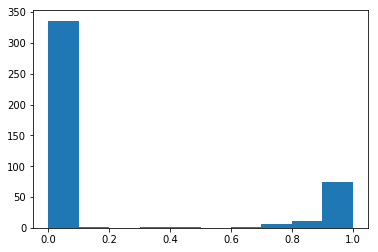

In [42]:
plt.hist(pred_probs[:,0]);

# Test Off Sample API

In [10]:
from requests import post
import json
import base64
from pathlib import Path
import shutil
from PIL import Image
import io

In [11]:
test_input_path = Path('/tmp/tmp/input')
image_paths = list(test_input_path.iterdir())
len(image_paths)

434

In [12]:
CHUNK_SIZE = 32

In [13]:
def make_image_paths_chunk_gen(image_paths, chunk_size):
    chunk_n = (len(image_paths) - 1) // chunk_size + 1
    image_path_chunks = [image_paths[i*chunk_size:(i+1)*chunk_size] for i in range(chunk_n)]
    
    for image_path_chunk in image_path_chunks:
        yield image_path_chunk

In [14]:
# image_path_chunk = next(make_image_paths_chunk_gen(image_paths, CHUNK_SIZE))

In [15]:
import base64

def convert_images_to_json(image_paths):
    base64_images = []
    for fp in image_paths:
        with open(fp, 'rb') as f:
            content = base64.b64encode(f.read()).decode()
            base64_images.append(content)
    doc = {
        'images': [{'content': content} for content in base64_images]
    }
    return doc

In [16]:
from requests import post, get

api_host = 'http://localhost:9876'

def call_api(uri, doc=None):
    if doc:
        resp = post(url=api_host + uri, json=doc)
    else:
        resp = get(url=api_host + uri)
    if resp.status_code == 200:
        return resp.json()
    else:
        raise Exception(resp.content.decode())

In [17]:
from time import sleep

while True:
    try:
        resp = call_api('/off-sample')
    except:
        print('Not ready...', end='\r')
    else:
        print(resp)
        break
    sleep(1)

{'host': 'f4c8453b093f', 'status': 'ok'}


In [18]:
# for i in range(14):
#     print(call_api('/off-sample'))

In [19]:
def predict_chunk(image_paths_chunk):
    input_doc = convert_images_to_json(image_paths_chunk)
    resp_doc = call_api('/off-sample/predict', input_doc)
    return resp_doc['predictions']

In [43]:
%%time

from concurrent.futures import ThreadPoolExecutor

threads = 4
max_images = CHUNK_SIZE * 2
with ThreadPoolExecutor(threads) as pool:
    futures = pool.map(predict_chunk, make_image_paths_chunk_gen(image_paths[:max_images], CHUNK_SIZE))
    predictions = list(p for preds in futures for p in preds)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 4.59 s


In [44]:
len(predictions)

64

In [53]:
n = 10
predictions[:n]

[{'prob': 0.00019018923921976238, 'label': 'on'},
 {'prob': 0.0014290218241512775, 'label': 'on'},
 {'prob': 0.9996521472930908, 'label': 'off'},
 {'prob': 0.00017550676420796663, 'label': 'on'},
 {'prob': 8.948405593400821e-05, 'label': 'on'},
 {'prob': 0.0007552606402896345, 'label': 'on'},
 {'prob': 1.9164632249157876e-05, 'label': 'on'},
 {'prob': 0.00041544626583345234, 'label': 'on'},
 {'prob': 0.0001525140687590465, 'label': 'on'},
 {'prob': 0.9993898868560791, 'label': 'off'}]

Label: on, Off-sample probability: 0.000


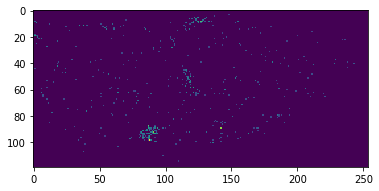

Label: on, Off-sample probability: 0.001


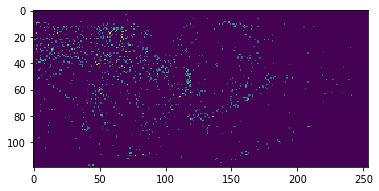

Label: off, Off-sample probability: 1.000


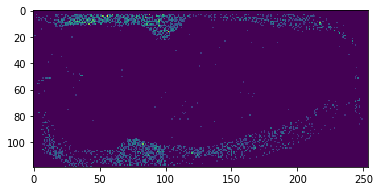

Label: on, Off-sample probability: 0.000


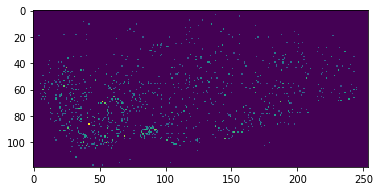

Label: on, Off-sample probability: 0.000


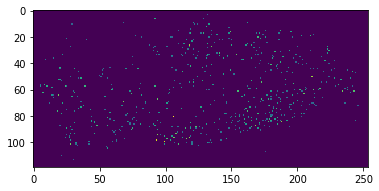

Label: on, Off-sample probability: 0.001


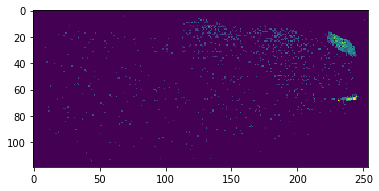

Label: on, Off-sample probability: 0.000


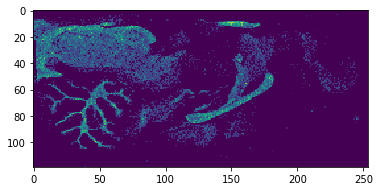

Label: on, Off-sample probability: 0.000


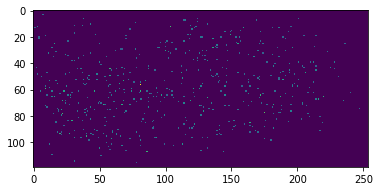

Label: on, Off-sample probability: 0.000


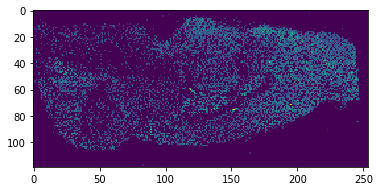

Label: off, Off-sample probability: 0.999


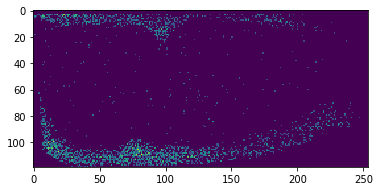

In [52]:
for img_path, pred in zip(image_paths[:n], predictions[:n]):
    img = np.array(Image.open(open(img_path, 'rb')))[:,:,0]
    print(f'Label: {pred["label"]}, Off-sample probability: {pred["prob"]:.3f}')
    plt.imshow(img)
    plt.show()